In [1]:
import os
from datetime import datetime

import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy.optimize import curve_fit

import docx
from docx import Document

In [2]:
CREATE_DOCX = True
CREATE_SVG = True

# outputDir = os.path.join('.', 'output')
outputDir = os.path.join('/home/jbecker', 'windows')

In [3]:
def linear_function(x, a, b):
    return a + b*x
def proportional(x, b):
    return b*x

In [4]:
# Assemble all JSON files into a single dataframe
XAVIER = 'Xavier NX'
TESLA = 'Tesla V100'

directories = [
    {'device': XAVIER, 'path': os.path.join('..', 'measurements', '20250103-173215505') },
#    {'device': TESLA,  'path': os.path.join('..', 'measurements', '20250101-231415558-fu') },
]

SCENARIOCOL = {
    'grayscale': '#BE5014',
    'blur-01': '#FFC000',
    'blur-02': '#4D93D9',
    'blur-03': '#D86DCD'
}
DEVICE_ORDER = { s: idx for idx, s in zip(range(0, len(directories)), [ entry['device'] for entry in directories ]) }

In [5]:
if CREATE_DOCX:
    outputDocx = Document()
    section = outputDocx.sections[0]
    # Landscape A3
    section.page_width = docx.shared.Inches(16.54)
    section.page_height = docx.shared.Inches(11.69)
    style = outputDocx.styles['Normal']
    style.font.size = docx.shared.Pt(8)
    
    def createOutputDocxFilename():
        now = datetime.now()
        timestamp = now.strftime('%Y%m%d-%H%M%S') + f"{now.microsecond // 1000:03d}"
        return timestamp + '.docx'
    outputDocxFilename = os.path.join(outputDir, createOutputDocxFilename())

if CREATE_DOCX or CREATE_SVG:
    os.makedirs(outputDir, exist_ok=True)

In [6]:
jsonData = []
for entry in directories:
    device = entry['device']
    dirpath = entry['path']
    filepath = os.path.join(dirpath, 'results.json')

    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)
        jsonData.append({
            'device': device,
            'data': data
        })

In [7]:
def createDfAll():
    dfs = []
    for record in jsonData:
        df = pd.DataFrame(record['data'])
        df.insert(0, 'device', record['device'])
        df.insert(df.columns.get_loc('height') + 1, 'pixels', df['width'] * df['height'])
        df.sort_values('pixels', inplace=True)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)
dfAll = createDfAll()

In [8]:
dfAll.columns

Index(['device', 'directory', 'image', 'width', 'height', 'pixels',
       'scenario_id', 'Exec Time (percent)', 'Exec Time (total)',
       'Exec Instances', 'Exec Time (avg.)', 'Exec Time (med.)',
       'Exec Time (min.)', 'Exec Time (max.)', 'Exec Time (std. dev.)',
       'Exec Name', 'Launch Time (percent)', 'Launch Time (total)',
       'Launch Instances', 'Launch Time (avg.)', 'Launch Time (med.)',
       'Launch Time (min.)', 'Launch Time (max.)', 'Launch Time (std. dev.)',
       'Launch Name', 'Memcpy To Device Time (percent)',
       'Memcpy To Device Time (total)', 'Memcpy To Device Instances',
       'Memcpy To Device Time (avg.)', 'Memcpy To Device Time (med.)',
       'Memcpy To Device Time (min.)', 'Memcpy To Device Time (max.)',
       'Memcpy To Device Time (std. dev.)', 'Memcpy To Device Name',
       'Memcpy To Host Time (percent)', 'Memcpy To Host Time (total)',
       'Memcpy To Host Instances', 'Memcpy To Host Time (avg.)',
       'Memcpy To Host Time (med.)', '

In [9]:
dfImageFileDescr = dfAll[['image', 'width', 'height', 'pixels']].drop_duplicates()
dfImageFileDescr

,image,width,height,pixels
0,01_small.jpg,100,100,10000
4,toledo01.jpg,320,214,68480
8,toledo02.jpg,640,428,273920
12,toledo03.jpg,800,535,428000
16,toledo04.jpg,1024,685,701440
20,02_medium.jpg,1200,675,810000
24,toledo05.jpg,1280,857,1096960
28,toledo06.jpg,2560,1713,4385280
32,03_large.jpg,5616,3744,21026304
36,toledo07.jpg,13226,8852,117076552


In [10]:
if CREATE_DOCX:
    def addDataFrameToDocx(docxObj, df):
        table = docxObj.add_table(rows=1, cols=len(df.columns))

        # Add header row to the table
        hdr_cells = table.rows[0].cells
        for i, column_name in enumerate(df.columns):
            hdr_cells[i].text = str(column_name)

        # Add data rows to the table
        for _, row in df.iterrows():
            row_cells = table.add_row().cells
            for i, value in enumerate(row):
                row_cells[i].text = str(value)
    
    # outputDocx = docx.Document()
    addDataFrameToDocx(outputDocx, dfImageFileDescr)
    outputDocx.save(outputDocxFilename)

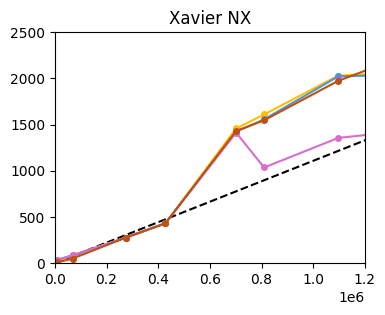

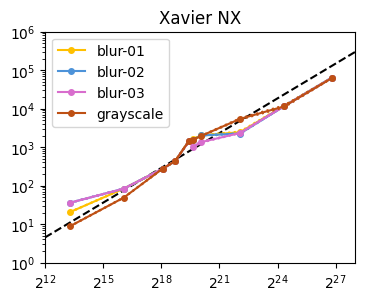

In [11]:
def createTransferToDevicePlots():
    transfer = 'Memcpy To Device'
    for device, grp in dfAll.groupby('device'):
        xmin_small = 0
        xmax_small = 1200000
        ymin_small = 0
        ymax_small = 2500
    
        xmin = 2**12
        xmax = 2**28
        ymin = 1
        ymax = 10**6
    
        df_small = grp[grp['pixels'] < xmax_small]
        x_small = df_small['pixels']
        y_small = df_small[f'{transfer} Time (avg.)']
        
        x = grp['pixels']
        y = grp[f'{transfer} Time (avg.)']
        (b,) = np.exp(curve_fit(lambda x, q: q + x, np.log(x), np.log(y))[0])
        
        fig = plt.figure(figsize=(4,3))
        xgrid = np.linspace(xmin, xmax, 2)
        plt.plot(xgrid, proportional(xgrid, b), color='black', linestyle='--')
        for scenario, g in grp.groupby('scenario_id'):
            #plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] - 1.28155 * g[f'{transfer} Time (std. dev.)'], linestyle='dotted', color=SCENARIOCOL[scenario])
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'], label=scenario, linestyle='solid', marker='.', ms=8, color=SCENARIOCOL[scenario])
            #plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] + 1.28155 * g[f'{transfer} Time (std. dev.)'], linestyle='dotted', color=SCENARIOCOL[scenario])
        plt.xlim(xmin_small, xmax_small)
        plt.ylim(ymin_small, ymax_small)
        plt.title(device)
        plt.show()
        if CREATE_SVG:
            abbrev = {
                TESLA: 'Tesla',
                XAVIER: 'Xavier'
            }
            fig.savefig(os.path.join(outputDir, f'transferHostDevice{abbrev[device]}LinScale.svg'), format='svg', bbox_inches='tight')    
            
        fig = plt.figure(figsize=(4,3))
        xgrid = np.linspace(xmin, xmax, 2)
        plt.plot(xgrid, proportional(xgrid, b), color='black', linestyle='--')
        for scenario, g in grp.groupby('scenario_id'):
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] - 1.64485 * g[f'{transfer} Time (std. dev.)'] / np.sqrt(g[f'{transfer} Instances']), linestyle='dotted', color=SCENARIOCOL[scenario])
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'], label=scenario, linestyle='solid', marker='.', ms=8, color=SCENARIOCOL[scenario])
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] + 1.64485 * g[f'{transfer} Time (std. dev.)'] / np.sqrt(g[f'{transfer} Instances']), linestyle='dotted', color=SCENARIOCOL[scenario])
        plt.xscale('log', base=2)
        plt.yscale('log', base=10)
        if min(x) < xmin or max(x) > xmax or min(y) < ymin or max(y) > ymax:
            raise RuntimeError('Limits not good')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.legend()
        plt.title(device)
        plt.show()
        if CREATE_SVG:
            abbrev = {
                TESLA: 'Tesla',
                XAVIER: 'Xavier'
            }
            fig.savefig(os.path.join(outputDir, f'transferHostDevice{abbrev[device]}LogLog.svg'), format='svg', bbox_inches='tight')    
    
        #print(f'a, b)

createTransferToDevicePlots()

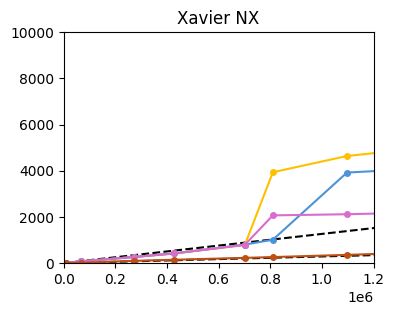

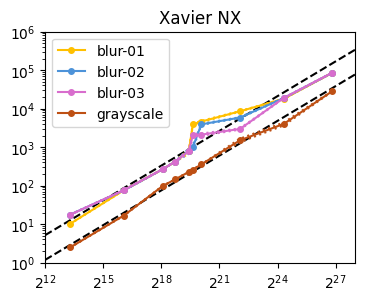

b_blur 0.0012641487011928391
b_grayscale 0.0002882192209598439


In [12]:
def createTransferToHostPlots():
    transfer = 'Memcpy To Host'
    for device, grp in dfAll.groupby('device'):
        xmin_small = 0
        xmax_small = 1200000
        ymin_small = 0
        ymax_small = 10000
    
        xmin = 2**12
        xmax = 2**28
        ymin = 1
        ymax = 10**6
    
        df_small = grp[grp['pixels'] < xmax_small]
        x_small = df_small['pixels']
        y_small = df_small[f'{transfer} Time (avg.)']

        grp_blur = grp[grp['scenario_id'] != 'grayscale']
        grp_grayscale = grp[grp['scenario_id'] == 'grayscale']
        x_blur = grp_blur['pixels']
        y_blur = grp_blur[f'{transfer} Time (avg.)']
        (b_blur,) = np.exp(curve_fit(lambda x, q: q + x, np.log(x_blur), np.log(y_blur))[0])
        x_grayscale = grp_grayscale['pixels']
        y_grayscale = grp_grayscale[f'{transfer} Time (avg.)']
        (b_grayscale,) = np.exp(curve_fit(lambda x, q: q + x, np.log(x_grayscale), np.log(y_grayscale))[0])
        
        fig = plt.figure(figsize=(4,3))
        xgrid = np.linspace(xmin, xmax, 2)
        plt.plot(xgrid, proportional(xgrid, b_blur), color='black', linestyle='--')
        plt.plot(xgrid, proportional(xgrid, b_grayscale), color='black', linestyle='--')
        for scenario, g in grp.groupby('scenario_id'):
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'], label=scenario, linestyle='solid', marker='.', ms=8, color=SCENARIOCOL[scenario])
        plt.xlim(xmin_small, xmax_small)
        plt.ylim(ymin_small, ymax_small)
        plt.title(device)
        plt.show()
        if CREATE_SVG:
            abbrev = {
                TESLA: 'Tesla',
                XAVIER: 'Xavier'
            }
            fig.savefig(os.path.join(outputDir, f'transferDeviceHost{abbrev[device]}LinScale.svg'), format='svg', bbox_inches='tight')    
    
        fig = plt.figure(figsize=(4,3))
        xgrid = np.linspace(xmin, xmax, 2)
        plt.plot(xgrid, proportional(xgrid, b_blur), color='black', linestyle='--')
        plt.plot(xgrid, proportional(xgrid, b_grayscale), color='black', linestyle='--')
        for scenario, g in grp.groupby('scenario_id'):
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] - 1.64485 * g[f'{transfer} Time (std. dev.)'] / np.sqrt(g[f'{transfer} Instances']), linestyle='dotted', color=SCENARIOCOL[scenario])
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'], label=scenario, linestyle='solid', marker='.', ms=8, color=SCENARIOCOL[scenario])
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] + 1.64485 * g[f'{transfer} Time (std. dev.)'] / np.sqrt(g[f'{transfer} Instances']), linestyle='dotted', color=SCENARIOCOL[scenario])
        plt.xscale('log', base=2)
        plt.yscale('log', base=10)
        if min(grp['pixels']) < xmin or max(grp['pixels']) > xmax or min(grp[f'{transfer} Time (avg.)']) < ymin or max(grp[f'{transfer} Time (avg.)']) > ymax:
            raise RuntimeError('Limits not good')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.legend()
        plt.title(device)
        plt.show()
        print(f'b_blur {b_blur}')
        print(f'b_grayscale {b_grayscale}')
        if CREATE_SVG:
            abbrev = {
                TESLA: 'Tesla',
                XAVIER: 'Xavier'
            }
            fig.savefig(os.path.join(outputDir, f'transferDeviceHost{abbrev[device]}LogLogScale.svg'), format='svg', bbox_inches='tight')    
    
        #print(f'a, b)

createTransferToHostPlots()

blur-01 0.006274112851672143
blur-02 0.010418988333108564
blur-03 0.015515095504089754
grayscale 0.0006031311255654515


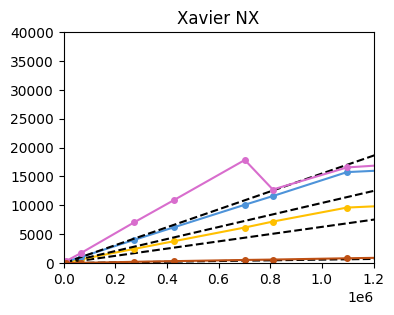

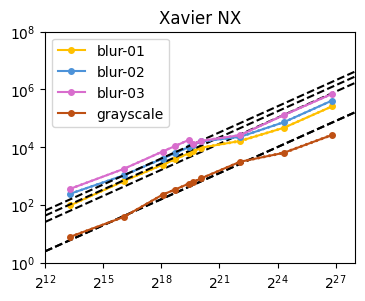

In [13]:
def createExecutionPlots():
    transfer = 'Exec'
    for device, grp in dfAll.groupby('device'):
        xmin_small = 0
        xmax_small = 1200000
        ymin_small = 0
        ymax_small = 40000
    
        xmin = 2**12
        xmax = 2**28
        ymin = 1
        ymax = 10**8
    
        df_small = grp[grp['pixels'] < xmax_small]
        x_small = df_small['pixels']
        y_small = df_small[f'{transfer} Time (avg.)']
        
        
        fig = plt.figure(figsize=(4,3))
        for scenario, g in grp.groupby('scenario_id'):
            x = g['pixels']
            y = g[f'{transfer} Time (avg.)']
            (b,) = np.exp(curve_fit(lambda x, q: q + x, np.log(x), np.log(y))[0])
            xgrid = np.linspace(xmin, xmax, 2)
            print(f'{scenario} {b}')
            plt.plot(xgrid, proportional(xgrid, b), color='black', linestyle='--')

            #plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] - 1.28155 * g[f'{transfer} Time (std. dev.)'], linestyle='dotted', color=SCENARIOCOL[scenario])
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'], label=scenario, linestyle='solid', marker='.', ms=8, color=SCENARIOCOL[scenario])
            #plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] + 1.28155 * g[f'{transfer} Time (std. dev.)'], linestyle='dotted', color=SCENARIOCOL[scenario])
        plt.xlim(xmin_small, xmax_small)
        plt.ylim(ymin_small, ymax_small)
        plt.title(device)
        plt.show()
        if CREATE_SVG:
            abbrev = {
                TESLA: 'Tesla',
                XAVIER: 'Xavier'
            }
            fig.savefig(os.path.join(outputDir, f'exec{abbrev[device]}LinearScale.svg'), format='svg', bbox_inches='tight')    
    
        fig = plt.figure(figsize=(4,3))
        xgrid = np.linspace(xmin, xmax, 2)
        plt.plot(xgrid, proportional(xgrid, b), color='black', linestyle='--')
        for scenario, g in grp.groupby('scenario_id'):
            x = g['pixels']
            y = g[f'{transfer} Time (avg.)']
            (b,) = np.exp(curve_fit(lambda x, q: q + x, np.log(x), np.log(y))[0])
            xgrid = np.linspace(xmin, xmax, 2)
            plt.plot(xgrid, proportional(xgrid, b), color='black', linestyle='--')

            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] - 1.64485 * g[f'{transfer} Time (std. dev.)'] / np.sqrt(g[f'{transfer} Instances']), linestyle='dotted', color=SCENARIOCOL[scenario])
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'], label=scenario, linestyle='solid', marker='.', ms=8, color=SCENARIOCOL[scenario])
            plt.plot(g['pixels'], g[f'{transfer} Time (avg.)'] + 1.64485 * g[f'{transfer} Time (std. dev.)'] / np.sqrt(g[f'{transfer} Instances']), linestyle='dotted', color=SCENARIOCOL[scenario])
        plt.xscale('log', base=2)
        plt.yscale('log', base=10)
        if min(x) < xmin or max(x) > xmax or min(y) < ymin or max(y) > ymax:
            raise RuntimeError('Limits not good')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.legend()
        plt.title(device)
        plt.show()
        if CREATE_SVG:
            abbrev = {
                TESLA: 'Tesla',
                XAVIER: 'Xavier'
            }
            fig.savefig(os.path.join(outputDir, f'exec{abbrev[device]}LogLogScale.svg'), format='svg', bbox_inches='tight')    
    
        #print(f'a, b)

createExecutionPlots()

In [81]:
def prepareTablesForScenarioMarginAnalysis(device, dd):
    dd = dd[dd['scenario_id'].isin(['blur-01', 'blur-02', 'blur-03'])]
    dd = dd[['image', 'scenario_id', 'pixels', 'Exec Time (avg.)']]
    dd.insert(1, 'margin', dd['scenario_id'].apply(lambda s: int(s[-1])))
    dd.drop('scenario_id', inplace=True, axis=1)
    dd2 = dd.copy()
    
    dd = dd.set_index(['image', 'margin']).unstack(level=1)
    col = dd[('pixels', 1)]
    dd = dd.drop(columns='pixels', level=0)
    dd.insert(0, 'pixels', col)
    dd.sort_values('pixels', inplace=True)
    return (dd, dd2)

dd, dd2 = prepareTablesForScenarioMarginAnalysis(XAVIER, dfAll[dfAll['device'] == XAVIER])
dd

pixels Exec Time (avg.)                          
margin                                  1            2            3
image                                                              
01_small.jpg       10000          96.1312     242.6390     359.8570
toledo01.jpg       68480         669.8496    1059.4554    1772.9827
toledo02.jpg      273920        2466.5974    4032.7414    7075.5494
toledo03.jpg      428000        3797.0765    6215.8189   10934.6698
toledo04.jpg      701440        6164.7389   10103.8470   17858.5891
02_medium.jpg     810000        7193.5971   11610.1754   12741.5907
toledo05.jpg     1096960        9616.1024   15757.1984   16567.0733
toledo06.jpg     4385280       16390.7098   22800.9104   26097.1462
03_large.jpg    21026304       47073.4669   73324.5475  129239.3485
toledo07.jpg   117076552      257292.9869  408917.0067  695612.9606

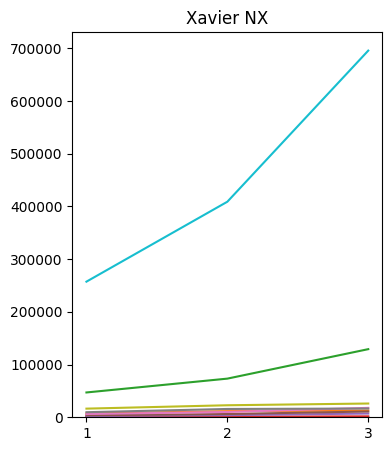

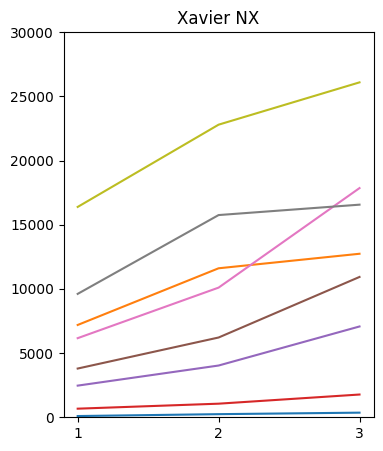

In [91]:
def createScenarioMarginFigures(device, dd2):
    fig = plt.figure(figsize=(4,5))
    for img, g in dd2.groupby('image'):
        gg = g.sort_values('margin')
        plt.plot(gg['margin'], gg['Exec Time (avg.)'])
    xvalues = np.array([1, 2, 3])
    plt.xticks(ticks=[1,2,3], labels=[1,2,3])
    plt.ylim(0)
    plt.title(device)
    plt.show()
    if CREATE_SVG:
        abbrev = {
            TESLA: 'Tesla',
            XAVIER: 'Xavier'
        }
        fig.savefig(os.path.join(outputDir, f'marginExecTimeScenarios{abbrev[device]}All.svg'), format='svg', bbox_inches='tight')    
    
    fig = plt.figure(figsize=(4,5))
    for img, g in dd2.groupby('image'):
        gg = g.sort_values('margin')
        plt.plot(gg['margin'], gg['Exec Time (avg.)'])
    xvalues = np.array([1, 2, 3])
    plt.xticks(ticks=[1,2,3], labels=[1,2,3])
    plt.ylim(0,30000)
    plt.title(device)
    plt.show()
    if CREATE_SVG:
        abbrev = {
            TESLA: 'Tesla',
            XAVIER: 'Xavier'
        }
        fig.savefig(os.path.join(outputDir, f'marginExecTimeScenarios{abbrev[device]}SmallOnly.svg'), format='svg', bbox_inches='tight')    

for device, grp in dfAll.groupby('device'):
    dd, dd2 = prepareTablesForScenarioMarginAnalysis(device, grp)
    createScenarioMarginFigures(device, dd2)